In order to be run, this Jupyter Python notebook requires that a number of specific Python modules (e.g. Fipy) are available; see all ``import`` statements. Also, it requires GNU Octave for executing the ``diffusion1Dspherical_FVTool.m`` script (to be placed in the same directory as this notebook) that calculates numerical solutions using FVTool.

GNU Octave: https://www.gnu.org/software/octave/

Fipy: https://www.ctcms.nist.gov/fipy/

FVTool: https://github.com/simulkade/FVTool

In [1]:
import sys
import numpy as np
from numpy import sqrt, exp, pi
from scipy.special import erf
import scipy.io as spio
import fipy as fp
import matplotlib.pyplot as plt
from fipy import numerix
import os.path

In [2]:
print('Python: ', sys.version)
print('Fipy v: ', fp.__version__)
print('Solver: ', fp.DefaultSolver)

Python:  3.8.1 | packaged by conda-forge | (default, Jan 29 2020, 14:55:04) 
[GCC 7.3.0]
Fipy v:  3.4.1
Solver:  <class 'fipy.solvers.petsc.linearGMRESSolver.LinearGMRESSolver'>


# Diffusion of an initial sphere into an infinite medium

M.H.V. Werts, 2020

Here, we study the diffusion equation in an infinite medium with the initial condition that all matter is homogeneously distributed in a sphere radius $a$, and no matter is outside of this sphere.

**Reference:** J. Crank (1975) "The Mathematics of Diffusion", 2nd Ed., 
      Clarendon Press (Oxford), pages 29-30, Equation 3.8, Figure 3.1

A system of spherical symmetry in a spherical coordinate system, *i.e.* "1D spherical", space coordinate $r$. Time $t$.

System parameters:

$a$ : radius of initial sphere; 
$c_0$ : concentration in initial sphere; 
$D$ : diffusion coefficient

Simple diffusion equation:

$$\frac{\partial c}{\partial t} = D \nabla^2 c$$

with initial condition:

$$ 
c(t = 0, r \leqslant a) = c_0 \quad \\ 
c(t = 0, r > a) = 0
$$



In [3]:
a = 1.0
C_0 = 1.0
D = 1.0

# Analytic solution

From Crank's "Mathematics of Diffusion" (2nd Ed., 1975), Chapter 3, we take Eqn 3.8 and Fig. 3.1.

Crank's Eqn 3.8 is coded below as the function ``C_sphere_infmed(r, t)``

In [4]:
# this evaluates Crank (1975), eqn. (3.8)
# a quick and dirty definition, with implicit globals
# should be checked against Carslaw & Jaeger
# but this form DOES reproduce Crank, fig. (3.1)
def C_sphere_infmed(r, t):
    term1 = erf((a-r)/(2*sqrt(D*t))) + erf((a+r)/(2*sqrt(D*t)))
    term2b = exp(-(a-r)**2/(4*D*t)) - exp(-(a+r)**2/(4*D*t))
    term2a = (D*t/pi) 
    C = 0.5 * C_0 * term1 - C_0/r * sqrt(term2a) * term2b
    return C

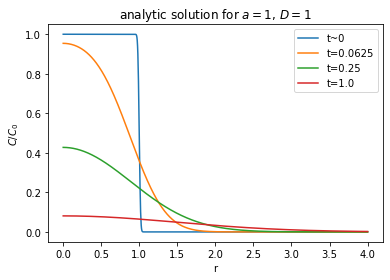

In [5]:
rr = np.linspace(0.001,4,1000)
plt.figure(2)
plt.clf()
plt.title('analytic solution for $a = 1$, $D = 1$')
plt.plot(rr, C_sphere_infmed(rr,0.0001),label='t~0')
plt.plot(rr, C_sphere_infmed(rr,0.0625),label='t=0.0625')
plt.plot(rr, C_sphere_infmed(rr,0.25),label='t=0.25')
plt.plot(rr, C_sphere_infmed(rr,1.0),label='t=1.0')
plt.ylabel('$C / C_0$')
plt.xlabel('r')
plt.legend()

The figure above is consistent with Figure 3.1 from Crank's book, demonstrating probable correctness of our code for evaluation of the analytic solution.

# Comparison with numerical solutions by FVTool and Fipy

In the following we will reproduce the curves at the different time points using FiPy and FVTool. FVTool is run separately (since it is Matlab/Octave) by calling it directly from this notebook. The results are stored in '.mat' files and are retrieved here.

We calculate the solution with Fipy and pull in the results from FVTool. Then, we compare with the analytic solution.

## FVTool

Concerning FVTool, it was observed that a very fine grid needs to be used. 50 cells is woofully insufficient (very imprecise result), 100 is slightly better, 500 seems to do OK, 1000 cells on 10 units width better still. We finally used 2000 cells over 10 units! We use smaller time-steps than with Fipy (0.0625/20 instead of 0.0625/10), but this does not change the final result much.

First we call command-line octave...

This generates '.mat' files which contain the solutions at the same time-points as in Crank's figure.

In [6]:
# only call the script if the first result file does not exist
if not os.path.exists('diffusion1Dspherical_FVTool_tstep20.mat'):
    !octave diffusion1Dspherical_FVTool.m
else:
    print('result file exists. did not run FVTool.')

AGMG 3.x linear solver is NOT available (Not necessary).
PVTtoolbox is NOT available (Not necessary).
FiniteVolumeToolbox has started successfully.
cellsum =  4188.8
t = 0
m_tot =  4.1263
ti = 0
n =  20
t =  0.062500
m_tot =  4.1263
filename = diffusion1Dspherical_FVTool_tstep20.mat
n =  60
t =  0.25000
m_tot =  4.1263
filename = diffusion1Dspherical_FVTool_tstep80.mat
n =  240
t =  1.0000
m_tot =  4.1263
filename = diffusion1Dspherical_FVTool_tstep320.mat


## Fipy

Fipy does not have a 1D spherical grid. Therefore we use a 2D cylindrical grid with a variable ``rs`` which contains the distance to the origin for each cell center.

We experimented with number of cells (moving to 200x200 instead of 120x120 does not change final result much)

In [7]:
boxsize = 120
msh = fp.CylindricalGrid2D(nr = boxsize, nz = boxsize, Lr = 10.0, Lz = 10.0)
rc = msh.cellCenters[0]
zc = msh.cellCenters[1]
rs = numerix.sqrt(rc**2 + zc**2)

First, we define the concentration cell variable and immediately initialize it with the initial condition

In [8]:
c = fp.CellVariable(name = 'c', mesh = msh, value = 0.)

In [9]:
c[rs<a] = C_0

The boundary conditions may be Dirichlet on the outer boundaries (right and top), and zero-flux on the inner boundaries (bottom and left). Zero-flux is implicit: if nothing is specified we have zero-flux.

Anyway, in the present case there is no difference between Dirichlet and zero-flux, showing that our grid is large enough to emulate an infinite medium.

In [10]:
## if this is commented out, we are using zero-flux!
#c.constrain(0., where = msh.facesRight)
#c.constrain(0., where = msh.facesTop)

We still need to define our transport equation

In [11]:
eq = fp.TransientTerm(var = c) == fp.DiffusionTerm(coeff = D, var = c)

Now, we initialize time $t$, and take the first time step.

In [12]:
t = 0. # master time
deltat = 0.0625/10

In [13]:
eq.solve(dt=deltat); t+=deltat

For plotting the Fipy solution after this first careful timestep, we only plot the values of the cells at the lowest $z$ ($z = 0$).

Text(0.5, 1.0, 't = 0.00625')

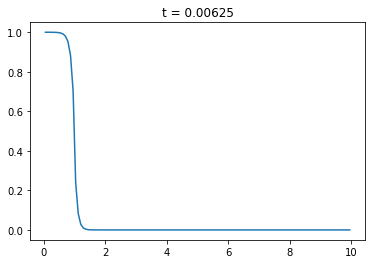

In [14]:
plt.plot(rs.value[0:boxsize],c.value[0:boxsize])
plt.title('t = {0:.5f}'.format(t))

Now we take 9 additional steps to arrive at $t = 0.0625$, the first time point in Crank's figure. Subsequently, we plot the concentration profile and compare it with the analytic profile and the result from FVTool.

In [15]:
# nine additional steps
for i in range(9):
    eq.solve(dt=deltat); t+=deltat

In [16]:
rr = np.linspace(0.001,5,1000) # for plotting analytic solution

In [17]:
# get result from FVTool
lm = spio.loadmat('diffusion1Dspherical_FVTool_tstep20.mat')
fvr = lm['x']
fvc = lm['cval']

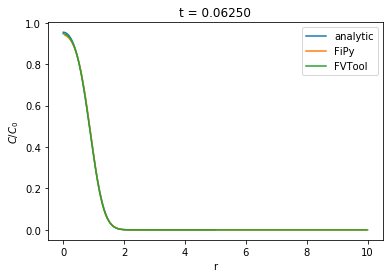

In [18]:
plt.plot(rr, C_sphere_infmed(rr,t), label = 'analytic')
plt.plot(rs.value[0:boxsize],c.value[0:boxsize], label = 'FiPy')
plt.plot(fvr,fvc, label = 'FVTool')
plt.title('t = {0:.5f}'.format(t))
plt.ylabel('$C / C_0$')
plt.xlabel('r')
plt.legend()

In [19]:
# thirty additional steps to arrive at next curve
for i in range(30):
    eq.solve(dt=deltat); t+=deltat

In [20]:
# get result from FVTool
lm = spio.loadmat('diffusion1Dspherical_FVTool_tstep80.mat')
fvr = lm['x']
fvc = lm['cval']

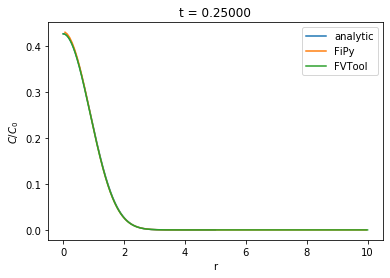

In [21]:
plt.plot(rr, C_sphere_infmed(rr,t), label = 'analytic')
plt.plot(rs.value[0:boxsize],c.value[0:boxsize], label = 'FiPy')
plt.plot(fvr,fvc, label = 'FVTool')
plt.title('t = {0:.5f}'.format(t))
plt.ylabel('$C / C_0$')
plt.xlabel('r')
plt.legend()

We can also calculate the difference between the analytic solution and the numerical results from Fipy and FVTool.

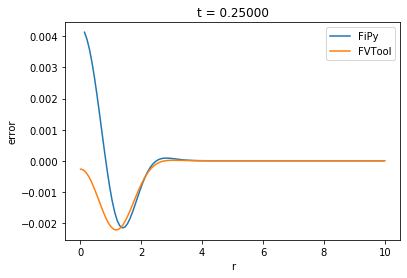

In [22]:
plt.plot(rs.value[1:boxsize],c.value[1:boxsize]-C_sphere_infmed(rs.value[1:boxsize],t), label = 'FiPy')
plt.plot(fvr[1:],fvc[1:]-C_sphere_infmed(fvr[1:],t), label = 'FVTool')
plt.title('t = {0:.5f}'.format(t))
plt.ylabel('error')
plt.xlabel('r')
plt.legend()

In [23]:
for i in range(120):
    eq.solve(dt=deltat); t+=deltat

In [24]:
# get result from FVTool
lm = spio.loadmat('diffusion1Dspherical_FVTool_tstep320.mat')
fvr = lm['x']
fvc = lm['cval']

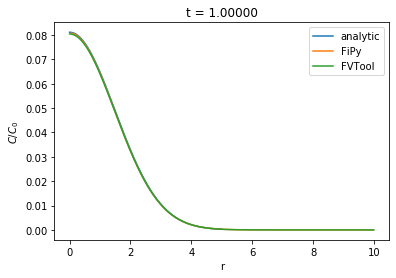

In [25]:
plt.plot(rr, C_sphere_infmed(rr,t), label = 'analytic')
plt.plot(rs.value[0:boxsize],c.value[0:boxsize], label = 'FiPy')
plt.plot(fvr,fvc, label = 'FVTool')
plt.title('t = {0:.5f}'.format(t))
plt.ylabel('$C / C_0$')
plt.xlabel('r')
plt.legend()

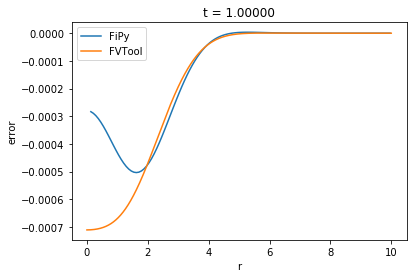

In [26]:
plt.plot(rs.value[1:boxsize],c.value[1:boxsize]-C_sphere_infmed(rs.value[1:boxsize],t), label = 'FiPy')
plt.plot(fvr[1:],fvc[1:]-C_sphere_infmed(fvr[1:],t), label = 'FVTool')
plt.title('t = {0:.5f}'.format(t))
plt.ylabel('error')
plt.xlabel('r')
plt.legend()

# Conclusion

This notebook shows that once the computational parameters for Fipy and FVTool have suitable values, close agreement is obtained with the analytic solution from [Crank 1975] for this particular diffusion problem. It also shows how to call FVTool and how to set up a simple calculation in spherical symmetry with Fipy.

It might be of interest to analyze the subtle differences between the analytic and numerical solutions. The FVTool calculation may be made more efficient by using unevenly sized cells: smaller cells near the initial sphere, larger cells farther away from the origin.